In [32]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score,precision_score
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime



In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

Pomu Capital has provided us with a dataset with two csv files: customer_data.csv and transactions_data.csv

customer data

In [34]:
customer_df = pd.read_csv('/content/drive/MyDrive/Fall 2023/Machine Learning/ML Project/analysis/customer_data.csv', low_memory=False)
customer_df.head(2)

,uid,business sector,location,phone number,national ID,passport,tin,gender,education level,business start date
0,9412e6f7-44a7-4268-8499-018a7bf9951a,Services,Bwindi,256759255957,13402677,U5096657,2578620,Male,Secondary,2020-03-10
1,afb7267f-ae22-4c74-a206-c3f274548e74,Services,Kampala,256767717430,86245593,U3285702,8553562,Male,Secondary,2014-04-08


In [35]:
# gives the rows, cols of the dataset(so as to have an idea of how much of the data we have that we can analyze)
customer_df.shape

(500, 10)

transacations data

In [36]:
# Get summary statistics for numeric columns, load the transactions data which has values that are of interest so as to
#know the performance index of each business

transactions_df = pd.read_csv('/content/drive/MyDrive/Fall 2023/Machine Learning/ML Project/analysis/transactions_data.csv', low_memory=False)
transactions_df.head(5)

,uid,amount,type,reason,date
0,9412e6f7-44a7-4268-8499-018a7bf9951a,783073.49,Debit,Sale,2020-03-29
1,9412e6f7-44a7-4268-8499-018a7bf9951a,890313.33,Credit,Purchase,2020-09-24
2,9412e6f7-44a7-4268-8499-018a7bf9951a,131290.16,Debit,Operating Expenses,2023-02-27
3,9412e6f7-44a7-4268-8499-018a7bf9951a,875566.10,Credit,Miscellaneous,2020-11-29
4,9412e6f7-44a7-4268-8499-018a7bf9951a,634225.06,Debit,Sale,2021-12-22


In [37]:
transactions_df.shape

(88436, 5)

## Data Exploration

### Summary statistics

Get the summary statistcis for numeric columns, this will help in understanding the distribution, identify outliers, data quality check, the feasibility of the predictive model(knowing how viable your data is) forexample if the businesses have the same transactions, it might be challenging to use that as a predictor model.

In [38]:

print(transactions_df['amount'].describe())

count     88436.000000
mean     499424.278113
std      288717.139104
min         118.950000
25%      249464.302500
50%      498800.570000
75%      749362.415000
max      999994.730000
Name: amount, dtype: float64


In [39]:
print(transactions_df.isnull().sum())

uid       0
amount    0
type      0
reason    0
date      0
dtype: int64


## Feature Engineering (Perfomance Index)
Inorder to better understand the data and prepare it for Machine Learning, we need to create new features to enable us to properly calculate the Business Perfomance Index.

### Clean the customer data df
- Remove columns from customer_df which are not needed for our analysis
- Add a new column to customer_df which shows the business duration
- Add new columns which calculate the perfomance index: some value containng business age and number and amount of transactions

In [40]:
customer_data_cleaned = customer_df.drop(columns=['phone number', 'national ID', 'passport', 'tin'])
customer_data_cleaned.head()

,uid,business sector,location,gender,education level,business start date
0,9412e6f7-44a7-4268-8499-018a7bf9951a,Services,Bwindi,Male,Secondary,2020-03-10
1,afb7267f-ae22-4c74-a206-c3f274548e74,Services,Kampala,Male,Secondary,2014-04-08
2,dca85456-0e9f-43f1-8c7c-62fff8691106,IT,Entebbe,Female,Vocational,2022-12-14
3,9223b5d4-88f8-468e-9931-6070a11ff58e,Hospitality,Mbale,Male,Secondary,2005-05-09
4,464f9a6f-0573-44de-8e6e-4bfb0ee77298,Hospitality,Mbale,Male,University,2017-01-19


Add business duration column

In [41]:
from datetime import datetime

#convert the business start date to date time so that we can calculate the business duration
customer_data_cleaned['business start date'] = pd.to_datetime(customer_data_cleaned['business start date'])

duration_in_days = (datetime.now() - customer_data_cleaned['business start date']).dt.days

duration_in_years = (duration_in_days / 365).round(2)

customer_data_cleaned['business duration (years)'] = duration_in_years

customer_data_cleaned.head()

,uid,business sector,location,gender,education level,business start date,business duration (years)
0,9412e6f7-44a7-4268-8499-018a7bf9951a,Services,Bwindi,Male,Secondary,2020-03-10,3.72
1,afb7267f-ae22-4c74-a206-c3f274548e74,Services,Kampala,Male,Secondary,2014-04-08,9.65
2,dca85456-0e9f-43f1-8c7c-62fff8691106,IT,Entebbe,Female,Vocational,2022-12-14,0.96
3,9223b5d4-88f8-468e-9931-6070a11ff58e,Hospitality,Mbale,Male,Secondary,2005-05-09,18.57
4,464f9a6f-0573-44de-8e6e-4bfb0ee77298,Hospitality,Mbale,Male,University,2017-01-19,6.86


### Add performance index column

Custom formula for *perfomance index*:

Perfomance Index =  (λ1 * Net Profit Per Year +  λ2 * Lifetime Net Profit + λ3 * Transaction Volume Per Year)


Where:

- λ1 is the weight for Net Profit Per Year
- λ2 is the weight for Transaction Volume Per Year
- λ3 is the weight for Lifetime Net Profit


In [42]:
# Calculate Net Profit
total_credit = transactions_df[transactions_df['type'] == 'Credit'].groupby('uid')['amount'].sum()
total_debit = transactions_df[transactions_df['type'] == 'Debit'].groupby('uid')['amount'].sum()
net_profit = total_credit.subtract(total_debit, fill_value=0)

# Calculate Transaction Volume
transaction_volume = transactions_df.groupby('uid').size()

# Merge net profit and transaction volume with customer_data on uid
customer_data_cleaned_with_net_profit = customer_data_cleaned.merge(net_profit.rename('Net Profit'), on='uid', how='left').fillna(0)
customer_data_cleaned_with_txn_vol = customer_data_cleaned_with_net_profit.merge(transaction_volume.rename('Transaction Volume'), on='uid', how='left').fillna(0)

# Calculate net profit per year and transaction volume per year
customer_data_cleaned_with_txn_vol['Net Profit Per Year'] = customer_data_cleaned_with_txn_vol['Net Profit'] / customer_data_cleaned_with_txn_vol['business duration (years)']
customer_data_cleaned_with_txn_vol['Transaction Volume Per Year'] = customer_data_cleaned_with_txn_vol['Transaction Volume'] / customer_data_cleaned_with_txn_vol['business duration (years)']

# Weights
λ1, λ2, λ3 = 1, 1, 1

# Calculate perfomance index considering lifetime profits
customer_data_cleaned_with_txn_vol['performance index'] = (λ1 * customer_data_cleaned_with_txn_vol['Net Profit Per Year'] +
                                  λ2 * customer_data_cleaned_with_txn_vol['Transaction Volume Per Year'] +
                                  λ3 * customer_data_cleaned_with_txn_vol['Net Profit'])

# Normalize the perfomance index:
min_val = customer_data_cleaned_with_txn_vol['performance index'].min()
max_val = customer_data_cleaned_with_txn_vol['performance index'].max()
customer_data_cleaned_with_txn_vol['Normalized Performance Index'] = (customer_data_cleaned_with_txn_vol['performance index'] - min_val) / (max_val - min_val)

customer_data_cleaned_with_txn_vol.head()

,uid,business sector,location,gender,education level,business start date,business duration (years),Net Profit,Transaction Volume,Net Profit Per Year,Transaction Volume Per Year,performance index,Normalized Performance Index
0,9412e6f7-44a7-4268-8499-018a7bf9951a,Services,Bwindi,Male,Secondary,2020-03-10,3.72,2964052.16,227,7.967882e+05,61.021505,3.760901e+06,0.616845
1,afb7267f-ae22-4c74-a206-c3f274548e74,Services,Kampala,Male,Secondary,2014-04-08,9.65,15937673.50,210,1.651572e+06,21.761658,1.758927e+07,0.739729
2,dca85456-0e9f-43f1-8c7c-62fff8691106,IT,Entebbe,Female,Vocational,2022-12-14,0.96,2368182.69,185,2.466857e+06,192.708333,4.835232e+06,0.626392
3,9223b5d4-88f8-468e-9931-6070a11ff58e,Hospitality,Mbale,Male,Secondary,2005-05-09,18.57,-6577294.51,233,-3.541893e+05,12.547119,-6.931471e+06,0.521829
4,464f9a6f-0573-44de-8e6e-4bfb0ee77298,Hospitality,Mbale,Male,University,2017-01-19,6.86,3065227.72,119,4.468262e+05,17.346939,3.512071e+06,0.614634


# Feature Engineering: Encoding
Now that we have the performance Index (PI) column well defined, we need to now focus on the features which will be used to predcit the PI. To better prepare out data from machine learning, most of it needs to be one-hot encoded since most of it is categorical.

#### Defining what we want encode

Business Sector, Location, Gender, Education level, business age, some value containng business age and number and amount of transactions

The features we choose should be abe to describe groups of rows (as compated to geatures like phone number)

#### Creating dummy varialbes/ encoding
Creating numerical values from categorical features can be approached in several ways.
The easiest is assigning a value to each value of a features. e.g
 Business Sector
    - Agriculture : 1
    - Service : 2
    - Fisheries : 3
However, this is not effecient for clustering algorithms as it will give inaccurate clusters

A better approach is the use of one-hot encoding, where a value is 1 and only 1 possibilty, while the rest are 0

In [43]:
categorical_columns = ['business sector', 'location', 'gender', 'education level']
customer_data_encoded = pd.get_dummies(customer_data_cleaned_with_txn_vol, columns=categorical_columns)

# Force convert all dummy variables to int
categorical_dummies = [col for col in customer_data_encoded.columns if any(prefix in col for prefix in categorical_columns)]
customer_data_encoded[categorical_dummies] = customer_data_encoded[categorical_dummies].astype(int)

customer_data_encoded = customer_data_encoded.drop(columns = ["performance index"])
customer_data_encoded.head(2)

,uid,business start date,business duration (years),Net Profit,Transaction Volume,Net Profit Per Year,Transaction Volume Per Year,Normalized Performance Index,business sector_Agriculture,business sector_Fisheries,...,location_Kisoro,location_Lira,location_Mbale,location_Mbarara,gender_Female,gender_Male,education level_Primary,education level_Secondary,education level_University,education level_Vocational
0,9412e6f7-44a7-4268-8499-018a7bf9951a,2020-03-10,3.72,2964052.16,227,7.967882e+05,61.021505,0.616845,0,0,...,0,0,0,0,0,1,0,1,0,0
1,afb7267f-ae22-4c74-a206-c3f274548e74,2014-04-08,9.65,15937673.50,210,1.651572e+06,21.761658,0.739729,0,0,...,0,0,0,0,0,1,0,1,0,0


#### Convert the business duration column into ranges (binning/dicretization)
##### todo: Use equal-frequency instead of equal-interval binning (before this, need to first draw a piechart of bar graph showing the difference in distribution of ranges)
psuedo code:
find the min value in duration column : e.g customer_data_encoded.min("")
find the max value in duration column
create ranges based on your judgeemnt. For exmaple if minimun is 1 and max is 10, then 3 ranges makes sense
create a new column in customer_data_encoded called business duration range and assign each row to it's range
e.g.: `uid``` `start`` `date`` `duration`` `duration range`` `other columens...``
        James WIlliam   ccds    2013-234          10.58      7 - 10 years


After that, one hot encode the  `duration range` column so that we have sth like:
`uid``` `start`` `date`` `duration`` `duration range_0 - 3 years`` `duration range_3 - 7 years` `duration range_7 - 10 years`
James WIlliam   ccds    2013-234          10.58       0                             0                                 1

In [44]:
# 1. Find the minimum and maximum values in the "business duration (years)" column
min_duration = customer_data_encoded['business duration (years)'].min()
max_duration = customer_data_encoded['business duration (years)'].max()

print("min is " + str(min_duration))
print("max is " + str(max_duration))
# 1. Define the specific bins
bins = [0, 5, 10, 15, 20.01]  # 20.01 is included to ensure businesses with exactly 20.01 years are also categorized

# 2. Create the labels
labels = ['0 - 5 years',
          '5 - 10 years',
          '10 - 15 years',
          '15 - 20 years']  # Notice the last label is '15 - 20 years', not '15 - 20.01 years' for display purposes

# 3. Create a new column called "business duration range" in the original dataframe and assign each row its respective range
customer_data_encoded['business duration range'] = pd.cut(customer_data_encoded['business duration (years)'], bins=bins, labels=labels, right=False, include_lowest=True)
duration_dummies = pd.get_dummies(customer_data_encoded['business duration range'], prefix='duration range')

duration_dummies = duration_dummies.astype(int)


# Extract rows for our own analysis
business_duration_ranges_df = customer_data_encoded.groupby('business duration range').size().reset_index(name='Number of Businesses')
business_duration_ranges_df.head()

# Reorder the columns
desired_order = ['uid', 'business start date', 'business duration (years)', 'business duration range'] + [col for col in customer_data_encoded if col not in ['uid', 'business start date', 'business duration (years)', 'business duration range']]
customer_data_encoded = customer_data_encoded[desired_order]

customer_data_encoded.head(2)


min is 0.21
max is 20.09


,uid,business start date,business duration (years),business duration range,Net Profit,Transaction Volume,Net Profit Per Year,Transaction Volume Per Year,Normalized Performance Index,business sector_Agriculture,...,location_Kisoro,location_Lira,location_Mbale,location_Mbarara,gender_Female,gender_Male,education level_Primary,education level_Secondary,education level_University,education level_Vocational
0,9412e6f7-44a7-4268-8499-018a7bf9951a,2020-03-10,3.72,0 - 5 years,2964052.16,227,7.967882e+05,61.021505,0.616845,0,...,0,0,0,0,0,1,0,1,0,0
1,afb7267f-ae22-4c74-a206-c3f274548e74,2014-04-08,9.65,5 - 10 years,15937673.50,210,1.651572e+06,21.761658,0.739729,0,...,0,0,0,0,0,1,0,1,0,0


#### Encode business ranges column

In [45]:
duration_dummies = pd.get_dummies(customer_data_encoded.get('business duration range',
  pd.Series(dtype=float)), prefix='duration range').astype(int)
customer_data_encoded = pd.concat([customer_data_encoded, duration_dummies], axis=1)
customer_data_encoded_range_dropped = customer_data_encoded.drop('business duration range', axis=1)

customer_data_encoded_range_dropped.head(2)

,uid,business start date,business duration (years),Net Profit,Transaction Volume,Net Profit Per Year,Transaction Volume Per Year,Normalized Performance Index,business sector_Agriculture,business sector_Fisheries,...,gender_Female,gender_Male,education level_Primary,education level_Secondary,education level_University,education level_Vocational,duration range_0 - 5 years,duration range_5 - 10 years,duration range_10 - 15 years,duration range_15 - 20 years
0,9412e6f7-44a7-4268-8499-018a7bf9951a,2020-03-10,3.72,2964052.16,227,7.967882e+05,61.021505,0.616845,0,0,...,0,1,0,1,0,0,1,0,0,0
1,afb7267f-ae22-4c74-a206-c3f274548e74,2014-04-08,9.65,15937673.50,210,1.651572e+06,21.761658,0.739729,0,0,...,0,1,0,1,0,0,0,1,0,0


#### Create transactions volume per year range column

In [46]:
# 1. Find the minimum and maximum transactions in the "Transaction Volume Per Year" column
min_transaction = customer_data_encoded_range_dropped['Transaction Volume Per Year'].min()
max_transaction = customer_data_encoded_range_dropped['Transaction Volume Per Year'].max()

print("min is " + str(min_transaction))
print("max is " + str(max_transaction))
bins = (0, 2000,4000,6000,8000,11000)

# 2. Create the labels
labels = ['0 - 2000',
          '2000 - 4000',
          '4000 - 6000',
          '6000 - 8000',
          '8000 - 11000']

customer_data_encoded_range_dropped['transaction volume range'] = pd.cut(customer_data_encoded_range_dropped['Transaction Volume Per Year'], bins=bins, labels=labels, right=False, include_lowest=True)


customer_data_encoded_range_dropped.head(2)

min is 2.879291251384275
max is 1171.4285714285716


,uid,business start date,business duration (years),Net Profit,Transaction Volume,Net Profit Per Year,Transaction Volume Per Year,Normalized Performance Index,business sector_Agriculture,business sector_Fisheries,...,gender_Male,education level_Primary,education level_Secondary,education level_University,education level_Vocational,duration range_0 - 5 years,duration range_5 - 10 years,duration range_10 - 15 years,duration range_15 - 20 years,transaction volume range
0,9412e6f7-44a7-4268-8499-018a7bf9951a,2020-03-10,3.72,2964052.16,227,7.967882e+05,61.021505,0.616845,0,0,...,1,0,1,0,0,1,0,0,0,0 - 2000
1,afb7267f-ae22-4c74-a206-c3f274548e74,2014-04-08,9.65,15937673.50,210,1.651572e+06,21.761658,0.739729,0,0,...,1,0,1,0,0,0,1,0,0,0 - 2000


Binning Create another column with at least 5 bins, which we will use to predict using KNN

In [47]:
# 1. Find the minimum and maximum transactions in the "Normalized Performance Index" column
min_pi = customer_data_encoded_range_dropped['Normalized Performance Index'].min()
max_pi = customer_data_encoded_range_dropped['Normalized Performance Index'].max()

print("min is " + str(min_pi))
print("max is " + str(max_pi))
bins = (0, 0.2, 0.4, 0.6, 0.8, 1.1)

# 2. Create the labels
labels = ['very low',
          'low',
          'medium',
          'high',
          'very high'
          ]

customer_data_encoded_range_dropped['PI_binned'] = pd.cut(customer_data_encoded_range_dropped['Normalized Performance Index'], bins=bins, labels=labels, right=False, include_lowest=True)


customer_data_encoded_range_dropped.head(2)

min is 0.0
max is 1.0


,uid,business start date,business duration (years),Net Profit,Transaction Volume,Net Profit Per Year,Transaction Volume Per Year,Normalized Performance Index,business sector_Agriculture,business sector_Fisheries,...,education level_Primary,education level_Secondary,education level_University,education level_Vocational,duration range_0 - 5 years,duration range_5 - 10 years,duration range_10 - 15 years,duration range_15 - 20 years,transaction volume range,PI_binned
0,9412e6f7-44a7-4268-8499-018a7bf9951a,2020-03-10,3.72,2964052.16,227,7.967882e+05,61.021505,0.616845,0,0,...,0,1,0,0,1,0,0,0,0 - 2000,high
1,afb7267f-ae22-4c74-a206-c3f274548e74,2014-04-08,9.65,15937673.50,210,1.651572e+06,21.761658,0.739729,0,0,...,0,1,0,0,0,1,0,0,0 - 2000,high


<Axes: >

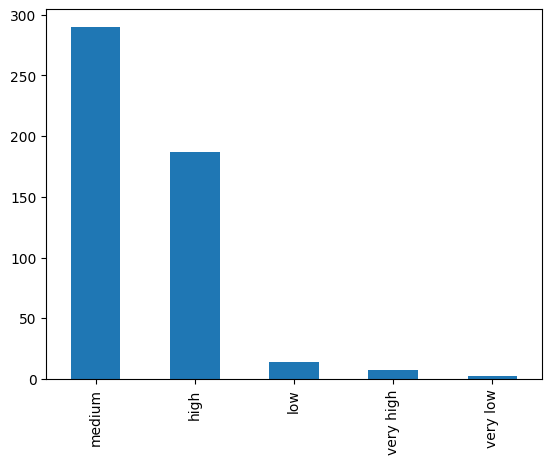

In [48]:
customer_data_encoded_range_dropped.PI_binned.value_counts().plot.bar()

<Axes: >

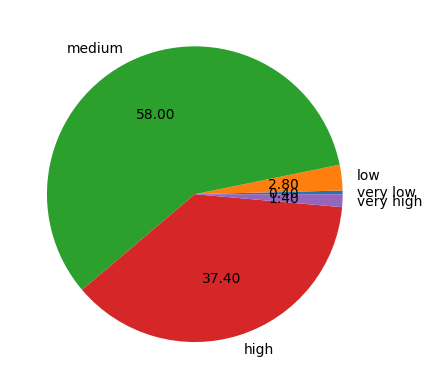

In [49]:
import matplotlib.pyplot as  plt
# customer_data_encoded_range_dropped.plot.pie(y='PI_binned', figsize=(5,5),labels=customer_data_encoded_range_dropped['PI_binned'])
# plt.show()

customer_data_encoded_range_dropped.groupby('PI_binned').size().plot(kind='pie', autopct='%.2f')

#### Encode transactions volume per year range

In [50]:
duration_dummies = pd.get_dummies(
    customer_data_encoded_range_dropped.get('transaction volume range', pd.Series(dtype=float)),
    prefix='transaction range'
).astype(int)

# Concatenating the dummy DataFrame with the original DataFrame
customer_data_encoded_range_dropped = pd.concat([customer_data_encoded_range_dropped, duration_dummies], axis=1)

customer_data_encoded_range_dropped = customer_data_encoded_range_dropped.drop('transaction volume range', axis=1, errors='ignore')

customer_data_encoded_range_dropped.head(2)

,uid,business start date,business duration (years),Net Profit,Transaction Volume,Net Profit Per Year,Transaction Volume Per Year,Normalized Performance Index,business sector_Agriculture,business sector_Fisheries,...,duration range_0 - 5 years,duration range_5 - 10 years,duration range_10 - 15 years,duration range_15 - 20 years,PI_binned,transaction range_0 - 2000,transaction range_2000 - 4000,transaction range_4000 - 6000,transaction range_6000 - 8000,transaction range_8000 - 11000
0,9412e6f7-44a7-4268-8499-018a7bf9951a,2020-03-10,3.72,2964052.16,227,7.967882e+05,61.021505,0.616845,0,0,...,1,0,0,0,high,1,0,0,0,0
1,afb7267f-ae22-4c74-a206-c3f274548e74,2014-04-08,9.65,15937673.50,210,1.651572e+06,21.761658,0.739729,0,0,...,0,1,0,0,high,1,0,0,0,0


Drop the transaction range Column, transaction vol per year, net profit per year, transaction volume colume, net profit columns.  Name the new data frame, transaction dropped data - encoded_with_transactions

In [51]:
dropped_data_encoded_with_transactions = customer_data_encoded_range_dropped.drop(columns=['Transaction Volume Per Year', 'Net Profit Per Year', 'Transaction Volume', 'Net Profit'])

dropped_data_encoded_with_transactions.head(2)

,uid,business start date,business duration (years),Normalized Performance Index,business sector_Agriculture,business sector_Fisheries,business sector_Hospitality,business sector_IT,business sector_Manufacturing,business sector_Retail,...,duration range_0 - 5 years,duration range_5 - 10 years,duration range_10 - 15 years,duration range_15 - 20 years,PI_binned,transaction range_0 - 2000,transaction range_2000 - 4000,transaction range_4000 - 6000,transaction range_6000 - 8000,transaction range_8000 - 11000
0,9412e6f7-44a7-4268-8499-018a7bf9951a,2020-03-10,3.72,0.616845,0,0,0,0,0,0,...,1,0,0,0,high,1,0,0,0,0
1,afb7267f-ae22-4c74-a206-c3f274548e74,2014-04-08,9.65,0.739729,0,0,0,0,0,0,...,0,1,0,0,high,1,0,0,0,0


## Predictive Modelling / Machine Learning
Now that our data is ready, we can finally use it for predicitive modelling

### Drop columns not needed for ML

In [52]:
encoded_data_cleaned = dropped_data_encoded_with_transactions.drop(columns = ['uid', 'business start date'])
encoded_data_cleaned.head(2)

,business duration (years),Normalized Performance Index,business sector_Agriculture,business sector_Fisheries,business sector_Hospitality,business sector_IT,business sector_Manufacturing,business sector_Retail,business sector_Services,location_Bwindi,...,duration range_0 - 5 years,duration range_5 - 10 years,duration range_10 - 15 years,duration range_15 - 20 years,PI_binned,transaction range_0 - 2000,transaction range_2000 - 4000,transaction range_4000 - 6000,transaction range_6000 - 8000,transaction range_8000 - 11000
0,3.72,0.616845,0,0,0,0,0,0,1,1,...,1,0,0,0,high,1,0,0,0,0
1,9.65,0.739729,0,0,0,0,0,0,1,0,...,0,1,0,0,high,1,0,0,0,0


In [53]:
encoded_data_cleaned.rename(columns={'Normalized Performance Index': 'performance_index'}, inplace=True)
customer_data_ml = encoded_data_cleaned.copy()
customer_data_ml.head(2)

,business duration (years),performance_index,business sector_Agriculture,business sector_Fisheries,business sector_Hospitality,business sector_IT,business sector_Manufacturing,business sector_Retail,business sector_Services,location_Bwindi,...,duration range_0 - 5 years,duration range_5 - 10 years,duration range_10 - 15 years,duration range_15 - 20 years,PI_binned,transaction range_0 - 2000,transaction range_2000 - 4000,transaction range_4000 - 6000,transaction range_6000 - 8000,transaction range_8000 - 11000
0,3.72,0.616845,0,0,0,0,0,0,1,1,...,1,0,0,0,high,1,0,0,0,0
1,9.65,0.739729,0,0,0,0,0,0,1,0,...,0,1,0,0,high,1,0,0,0,0


Binning Create another column with at least 5 bins

## KNN

KNN algorithm to predict PI. With KNN, we will test with different values of k to find which k gives the best accuracy. For example with k=5, up to k=10. But to ensure accuracy, we  will run 10 fold  cross validation for each value of k.

The result showed that k = 8 (hypothetical) gave the most accurate prediction for KNN.



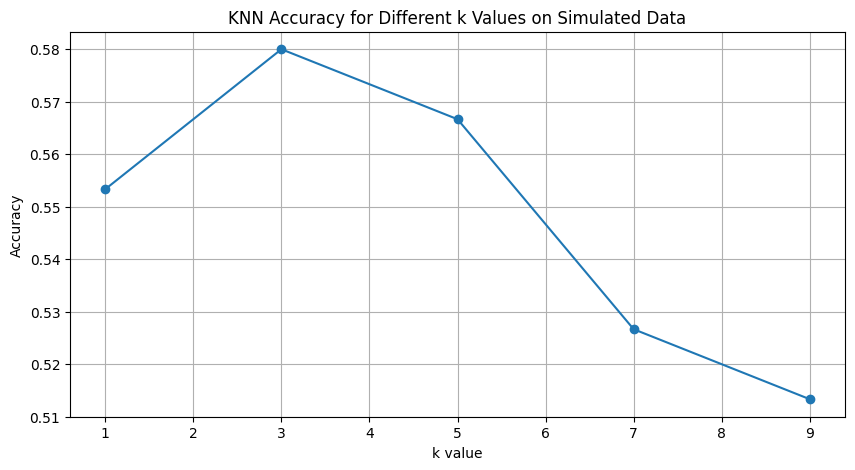

In [54]:
X = customer_data_ml.drop(columns=['PI_binned'], axis=1)
y = customer_data_ml['PI_binned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training and evaluating the KNN model for different k values
k_values = range(1, 10, 2)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Compute and store the accuracy
    accuracies.append(knn.score(X_test, y_test))


# Plotting the results for accuracy
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different k Values on Simulated Data')
plt.grid(True)
plt.show()

From the above experiment, we can see that our best value of k is 3. We get the highest score the k=3, so we can use this value for the final KNN algorithm below:

In [55]:
X = customer_data_ml.drop(columns=['PI_binned'], axis=1)
y = customer_data_ml['PI_binned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


print("the score for k = 3 is" + str(knn.score(X_test, y_test)))

print("========= Confusion matrix for KNN ========")
confusion_matrix(y_test, y_pred)

the score for k = 3 is0.58
========= Confusion matrix for KNN ========


array([[21,  1, 34,  0],
       [ 1,  2,  3,  0],
       [22,  0, 64,  1],
       [ 0,  0,  1,  0]])

## Decision Tree

In [56]:
from sklearn import tree

X = customer_data_ml.drop(columns=['PI_binned'], axis=1)
y = customer_data_ml['PI_binned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = tree.DecisionTreeClassifier(criterion="entropy")
clf.fit (X_train, y_train)

y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print("========= Confusion matrix for Decision Tree ========")
print(confusion)


========= Confusion matrix for Decision Tree ========
[[56  0  0  0]
 [ 0  6  0  0]
 [ 0  0 87  0]
 [ 1  0  0  0]]


##  Random Forest model
Note: Random Forest in scikit-learn expects a numerical input, so any categorical data must be converted into a numerical format before training the model. We do have 5 categories for PI_binned which are very low, low, medium, high, very high. The first step is to use label encoding as we want to maintain a single column, with each category represented by a unique integer, its a diffent case if we use One-Hot encoding as it will create several columns yet we need one column for our independent variable.

In [57]:

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
customer_data_ml['PI_binned_encoded'] = label_encoder.fit_transform(customer_data_ml['PI_binned'])


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

random_forest_data = customer_data_ml.drop(columns = ['PI_binned'], axis=1)

X = random_forest_data.drop(columns = ['PI_binned_encoded'], axis=1)
y = random_forest_data['PI_binned_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit (X_train, y_train)

y_pred = random_forest.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print("========= Confusion matrix for Random Forest ========")
print(confusion)


========= Confusion matrix for Random Forest ========
[[56  0  0  0]
 [ 0  0  6  0]
 [ 0  0 87  0]
 [ 1  0  0  0]]


## Ensemble

In [59]:
# your ensemble code to combine some of the algos above to see if accuracy improves
from sklearn.svm import SVC
from statistics import mode

# Train the models
knn = KNeighborsClassifier(n_neighbors=3)
clf = tree.DecisionTreeClassifier(criterion="entropy")
rf = RandomForestClassifier(n_estimators=100, random_state=42)


knn.fit(X_train, y_train)
clf.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predictions
y_pred_knn = knn.predict(X_test)
y_pred_clf = clf.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Majority voting
final_pred = [mode([i, j, k]) for i, j, k in zip(y_pred_knn, y_pred_clf, y_pred_rf)]

# Confusion Matrix
confusion = confusion_matrix(y_test, final_pred)
print("========= Confusion Matrix from Majority Voting ========")
print(confusion)


========= Confusion Matrix from Majority Voting ========
[[56  0  0  0]
 [ 1  2  3  0]
 [ 0  0 87  0]
 [ 1  0  0  0]]


## Conclusion - Best performing Algorithm

Based on the above experiments with different Machine Learning models, the most accurate was Random Forest. This can be attributed to how our data is structured, the diversity of columns we have, and the quantity of data we have. (clean this up)

### Accuracy of the models

#### KNN
========= Confusion matrix for KNN ========

```
[[20,  1, 35,  0],
[ 1,  2,  3,  0],
[22,  0, 64,  1],
[ 0,  0,  1,  0]]
```


Total number of cases = 20 + 1 + 3 + 35 + 1 + 2 + 3 + 22 + 64 + 1 + 1= 150

20 + 2 + 64 = 86
86/150 = 0.573
Which is **57%**


#### Decision Tree

========= Confusion matrix for Decision Tree ========



```
[[56  0  0  0]
[0  6  0  0]
[ 0  0 87  0]
[ 0  0  0  1]]
```



Total number of cases = 56 + 6+87+1= 150
Correct predictions = 150
150/150 = 1
**1%** correct


#### Random forest

========= Confusion matrix for Random Forest ========


```
[[56  0  0  0]
 [ 0  0  6  0]
 [ 0  0 87  0]
 [ 1  0  0  0]]
```

Total number of cases = 56 + 6 + 87 = 147
Correct predictions = 56 + 0+ 87 + 0 = 148
143/147 = 0.972
**97% **correct


#### Ensemble

========= Confusion Matrix from Majority Voting ========


```
[[56  0  0  0]
 [ 1  2  3  0]
 [ 0  0 87  0]
 [ 1  0  0  0]]
```




Total number of cases = 56 + 1 + 2 + 3 + 87+1 = 150
Correct predictions = 56 + 2 + 87 + 0 = 145
145/150 = 0.966
**96.6%** correct


Based off this calculation, **the most accurate model is Random Forest**  since it has the highers accuracy of 97%

## Predicting PI for a new business

The Random Forest model was the most accurate model. We can now use for this prediction of business perfomance (`PI_binned`).

PomuCapital wsa able to provide some more new customer data for us to taste our model. This data will be used in the prediction below.

#### Perfomance Index prediction

In [60]:
single_customer_df = pd.read_csv('/content/drive/MyDrive/Fall 2023/Machine Learning/ML Project/analysis/single_customer_data.csv', low_memory=False)
single_customer_df.head()

,uid,business sector,location,phone number,national ID,passport,tin,gender,education level,business start date
0,aef4b9fa-5402-4967-9f1a-3921665ddf84,Agriculture,Jinja,256772298984,83433993,U4603610,7042452,Female,University,2009-06-15


In [64]:
single_customer_transactions_df = pd.read_csv('/content/drive/MyDrive/Fall 2023/Machine Learning/ML Project/analysis/single_customer_transactions_data.csv', low_memory=False)
single_customer_transactions_df.head()

,uid,amount,type,reason,date
0,aef4b9fa-5402-4967-9f1a-3921665ddf84,480560.44,Debit,Purchase,2019-12-15
1,aef4b9fa-5402-4967-9f1a-3921665ddf84,28991.72,Debit,Refund,2019-04-20
2,aef4b9fa-5402-4967-9f1a-3921665ddf84,55789.91,Credit,Sale,2023-10-17
3,aef4b9fa-5402-4967-9f1a-3921665ddf84,403996.93,Debit,Operating Expenses,2014-12-28
4,aef4b9fa-5402-4967-9f1a-3921665ddf84,432391.08,Credit,Miscellaneous,2022-06-27


#### Format the new customer data dfs
 Format the dfs such that we get a new cusomter df with the same columns as customer_data_ml so that we can feed the data into the Random forest model

In [79]:
def fomart_new_customer_data_for_prediction_model(single_customer_df, single_customer_transactions_df):
  from datetime import datetime

  # drop unwanted columns
  single_customer_data_cleaned = single_customer_df.drop(columns=['phone number', 'national ID', 'passport', 'tin'])
  #single_customer_data_cleaned.head()

  #add business duration column
  #convert the business start date to date time so that we can calculate the business duration
  single_customer_data_cleaned['business start date'] = pd.to_datetime(single_customer_data_cleaned['business start date'])
  duration_in_days = (datetime.now() - single_customer_data_cleaned['business start date']).dt.days
  duration_in_years = (duration_in_days / 365).round(2)
  single_customer_data_cleaned['business duration (years)'] = duration_in_years
  #single_customer_data_cleaned.head()

  # Calculate Net Profit
  total_credit = single_customer_transactions_df[single_customer_transactions_df['type'] == 'Credit'].groupby('uid')['amount'].sum()
  total_debit = single_customer_transactions_df[single_customer_transactions_df['type'] == 'Debit'].groupby('uid')['amount'].sum()
  net_profit = total_credit.subtract(total_debit, fill_value=0)

  # Calculate Transaction Volume
  transaction_volume = single_customer_transactions_df.groupby('uid').size()

  # Merge net profit and transaction volume with customer_data on uid
  customer_data_cleaned_with_net_profit = single_customer_data_cleaned.merge(net_profit.rename('Net Profit'), on='uid', how='left').fillna(0)
  customer_data_cleaned_with_txn_vol = customer_data_cleaned_with_net_profit.merge(transaction_volume.rename('Transaction Volume'), on='uid', how='left').fillna(0)

  # Calculate net profit per year and transaction volume per year
  customer_data_cleaned_with_txn_vol['Net Profit Per Year'] = customer_data_cleaned_with_txn_vol['Net Profit'] / customer_data_cleaned_with_txn_vol['business duration (years)']
  customer_data_cleaned_with_txn_vol['Transaction Volume Per Year'] = customer_data_cleaned_with_txn_vol['Transaction Volume'] / customer_data_cleaned_with_txn_vol['business duration (years)']


  categorical_columns = ['business sector', 'location', 'gender', 'education level']
  customer_data_encoded = pd.get_dummies(customer_data_cleaned_with_txn_vol, columns=categorical_columns)

  # Force convert all dummy variables to int
  categorical_dummies = [col for col in customer_data_encoded.columns if any(prefix in col for prefix in categorical_columns)]
  customer_data_encoded[categorical_dummies] = customer_data_encoded[categorical_dummies].astype(int)
  #customer_data_encoded.head()

  # Fitting the new data to have the same feature space as the data used to train the model:
  trained_model_columns = list(X_train.columns)

  # Add missing columns with default value of 0
  for column in trained_model_columns:
      if column not in customer_data_encoded.columns:
          customer_data_encoded[column] = 0

  # Ensure the order of columns matches the trained model
  customer_data_encoded = customer_data_encoded[trained_model_columns]
  #customer_data_encoded.head()
  return customer_data_encoded




In [80]:
customer_data_encoded = fomart_new_customer_data_for_prediction_model(single_customer_df, single_customer_transactions_df)
customer_data_encoded.head()

,business duration (years),performance_index,business sector_Agriculture,business sector_Fisheries,business sector_Hospitality,business sector_IT,business sector_Manufacturing,business sector_Retail,business sector_Services,location_Bwindi,...,education level_Vocational,duration range_0 - 5 years,duration range_5 - 10 years,duration range_10 - 15 years,duration range_15 - 20 years,transaction range_0 - 2000,transaction range_2000 - 4000,transaction range_4000 - 6000,transaction range_6000 - 8000,transaction range_8000 - 11000
0,14.47,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally making a prediction:

In [81]:
predicted_labels = random_forest.predict(customer_data_encoded)
original_labels = label_encoder.inverse_transform(predicted_labels)
print("The prediction for the new business data is: " + str (original_labels[0]))

The prediction for the new business data is: medium


## Conclusion